13-1. 들어가며
***

13-2. 조건 없는 생성모델(Unconditional Generative Model), GAN

- GAN 생성 모델의 문제점을 파악
***

13-3. 조건 있는 생성모델(Conditional Generative Model), cGAN

- cGAN 모델의 구조를 파악하고, GAN과 차이점이 무엇인지 학습
***

13-4. 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기

13-5. 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기

13-6. 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기

- GAN과 cGAN의 Generator와 Discriminator를 각각 구현하고, 학습 및 테스트를 진행
***

13-7. GAN의 입력에 이미지를 넣는다면? Pix2Pix

- Pix2Pix의 Generator와 Discriminator, Loss function에 대해
***

13-8. 난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기

13-9. 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기

13-10. 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기

13-11. 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기

13-12. 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기

- Pix2Pix 모델을 구현하고, 학습 및 테스트를 진행
***

## 조건 없는 생성모델(Unconditional Generative Model), GAN

GAN의 문제점
-  내가 원하는 종류의 이미지를 바로 생성해 내지 못한다는 것
- GAN의 생성자와 판별자가 경쟁하는 과정에서 균형을 유지하기 어려워 학습이 불안정해지는 경향이 o
- 생성자가 판별자를 속이기 어려워지면서 동일하거나 유사한 이미지를 반복적으로 생성하는 Model collapsing 문제

GAN 구조는 Generator 및 Discriminator라 불리는 두 신경망이 minimax game을 통해 서로 경쟁하며 발전

    <GAN의 목적 함수>
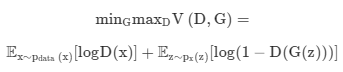
z는 임의 노이즈를, D와 G는 각각 Discriminator 및 Generator를 의미

D의 입장,

    진짜 데이터(x)를 진짜로, 가짜 데이터(G(z))를 가짜로 정확히 예측하도록 학습

G의 입장,

    z를 입력받아 생성한 데이터 G(z)를 D가 진짜 데이터라고 예측할 만큼 진짜 같은 가짜 데이터를 만들도록 학습

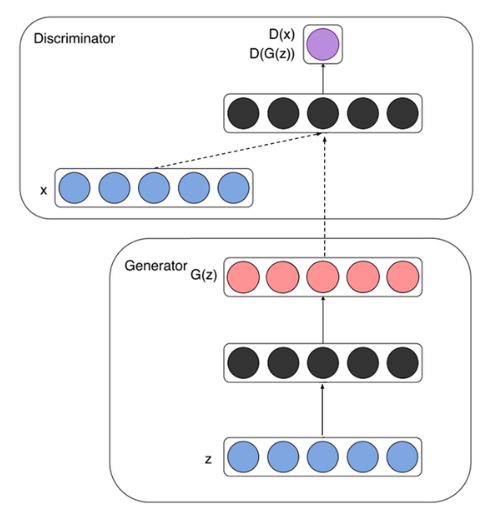

## 조건 있는 생성모델(Conditional Generative Model), cGAN

내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여, 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법

    <cGAN의 목적 함수>
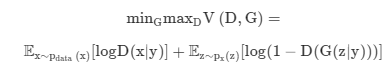
바뀐 부분은 우변의 + 를 기준으로 양쪽 항에 y가 추가

y가 임의 노이즈 입력인 z의 가이드

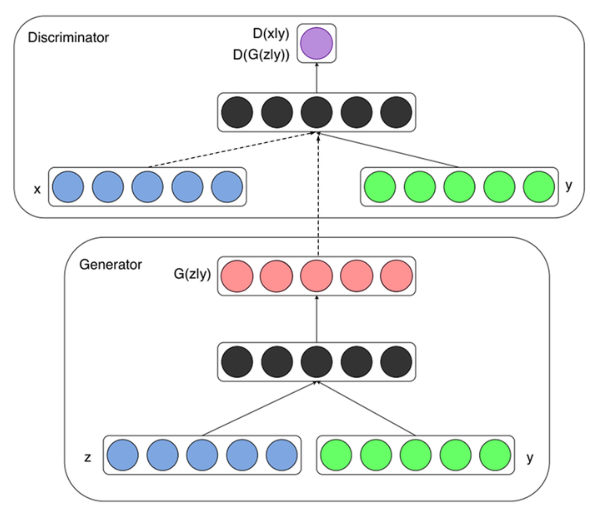

## 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기

tensorflow-datasets 라이브러리에서 간단하게 MNIST 데이터셋을 불러와 확인

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


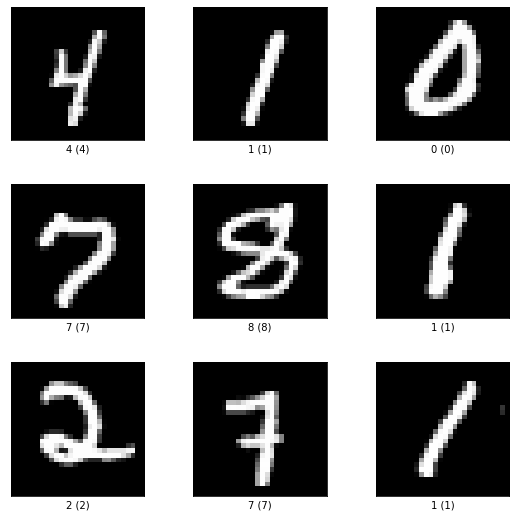

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

학습 전에 필요한 몇 가지 처리를 수행하는 함수를 정의
- 이미지 픽셀 값을 -1~1 사이의 범위로 변경
- 레이블 정보를 원-핫 인코딩(one-hot encoding)
->GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 gan_preprocessing()과 cgan_preprocessing() 두 가지 함수를 구성

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


### 질문1.
이미지 픽셀 값을 -1~1 사이의 범위로 변경하는 이유?

A. 정규화된 픽셀 값을 사용함으로써 모델의 안정성이 향상될 수 있고, 데이터 분포의 평균을 0으로 맞추고 단위 분산을 갖도록 조정하여 모델의 학습 효율을 향상시키는 효과
***

원하는 대로 정확히 처리되었는지 한 개 데이터셋만 선택해 확인
-  이미지에 쓰인 숫자와 레이블이 일치해야 하고,
- 이미지 값의 범위가 -1~1 사이

Label : tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


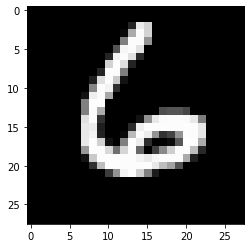

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

GAN Generator 구성하기
***

In [4]:
#주석에 맞춰 Generator를 만들어주세요.

from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self): # 레이어 구성
        super(GeneratorGAN, self).__init__()

        # 활성화함수를 'relu'를 사용하고 unit이 128인 Dense Layer를 정의해주세요,.
        self.dense_1 = layers.Dense(128, activation='relu')
        # 활성화함수를 'relu'를 사용하고 unit이 256인 Dense Layer를 정의해주세요.
        self.dense_2 = layers.Dense(256, activation='relu')
        # 활성화함수를 'relu'를 사용하고 unit이 512인 Dense Layer를 정의해주세요.
        self.dense_3 = layers.Dense(512, activation='relu')
        # 활성화함수를 하이퍼볼릭 탄젠트를 사용하고 unit이 784인 Dense Layer를 정의해주세요.
        self.dense_4 = layers.Dense(28*28, activation='tanh')
        # 모양일 (28,28,1)로 변경해주세요.
        # self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise): # forward propagation을 진행
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        # out = self.final_dense(out)
        return self.reshape(out)

print("✅")

✅


### 질문2.
마지막에 activation을 relu가 아닌 tanh를 쓰는 이유?

A. 
***

cGAN Generator 구성하기
***

In [5]:
#주석에 맞춰 Generator를 만들어주세요.

class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        # 노이즈에 Dense layer를 적용시킵니다.
        noise = self.dense_z(noise)
         # 라벨에 Dense layer를 적용시킵니다.
        label = self.dense_y(label)
        # 노이즈와 라벨을 pair가 되게 합친 다음 combined_dense를 적용시킵니다. (힌트 : https://www.tensorflow.org/api_docs/python/tf/concat)
#         out = layers.Concatenate()([image, label])
        combined_input = layers.concatenate([noise, label], axis=-1)
        out = self.combined_dense(combined_input)
        # 마지막 Dense Layer를 적용시킵니다.
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


두 구조의 차이점은 레이블 정보가 추가된다는 것뿐

cGAN의 입력은 2개(노이즈 및 레이블 정보)라는 점을 기억

## 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기

GAN Discriminator 구성하기
***

In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        #해당 방식은 반복문을 활용해 layer를 쌓기 때문에 좋은 테크닉중 하나입니다,.
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이며, 이를 fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용

이어서 레이어들이 쌓여있는 blocks에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과

마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력

***
cGAN Discriminator 구성하기
***

cGAN의 Discriminator는 Maxout이라는 특별한 레이어가 사용

Maxout은 간단히 설명하면 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 함

In [7]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("✅")

✅


Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개만큼 만들고 그중 최댓값을 출력

Maxout 레이어를 3번만 사용하면 아래와 같이 쉽게 cGAN의 Discriminator를 구성

In [8]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


GAN의 Discriminator와 마찬가지로 Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, layers.Flatten()이 적용

그리고 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한 번씩 통과한 후 서로 결합되어 Maxout 레이어를 한 번 더 통과

마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력

## 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기

우선 GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의

진짜 및 가짜를 구별하기 위해 Binary Cross Entropy를 사용하고, Adam optimizer를 이용해 학습

In [9]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


***
GAN으로 MNIST 학습하기
***

GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용

In [10]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


10 epoch만큼 학습을 진행

100번의 반복마다 각 손실(loss)을 출력

In [11]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.382094383239746, D:0.10916868597269058
[1/10 EPOCHS, 200 ITER] G:2.621856451034546, D:0.10998517274856567
[1/10 EPOCHS, 300 ITER] G:2.9129395484924316, D:0.14284975826740265
[1/10 EPOCHS, 400 ITER] G:3.517263174057007, D:0.06462494283914566
[2/10 EPOCHS, 100 ITER] G:3.57067608833313, D:0.09718169271945953
[2/10 EPOCHS, 200 ITER] G:3.423311948776245, D:0.22899939119815826
[2/10 EPOCHS, 300 ITER] G:3.9743361473083496, D:0.16919225454330444
[2/10 EPOCHS, 400 ITER] G:2.6405391693115234, D:0.3375586271286011
[3/10 EPOCHS, 100 ITER] G:1.7951128482818604, D:0.27084821462631226
[3/10 EPOCHS, 200 ITER] G:3.0162153244018555, D:0.1749732792377472
[3/10 EPOCHS, 300 ITER] G:3.2869038581848145, D:0.09062853455543518
[3/10 EPOCHS, 400 ITER] G:2.858156204223633, D:0.1332138478755951
[4/10 EPOCHS, 100 ITER] G:3.8214755058288574, D:0.18459317088127136
[4/10 EPOCHS, 200 ITER] G:3.991384983062744, D:0.33527126908302307
[4/10 EPOCHS, 300 ITER] G:3.0584537982940674, D:0.252035498

모델을 테스트

100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화

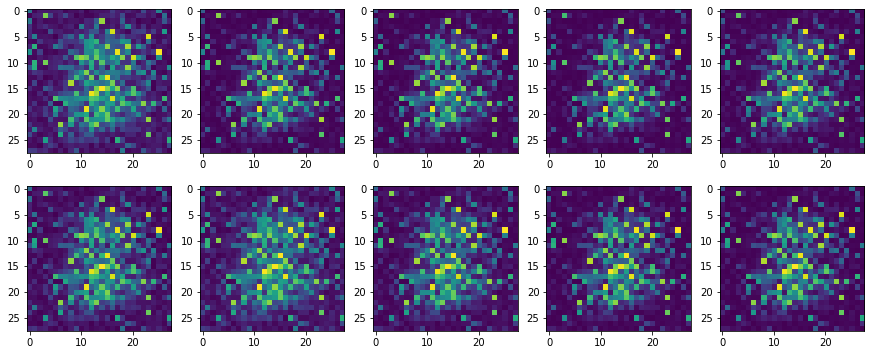

In [12]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

결과를 보니 아마도 10 epoch의 학습만으로는 좋은 결과를 기대할 수 x

 500 epoch 학습한 가중치를 준비해 두었으니 한번 사용

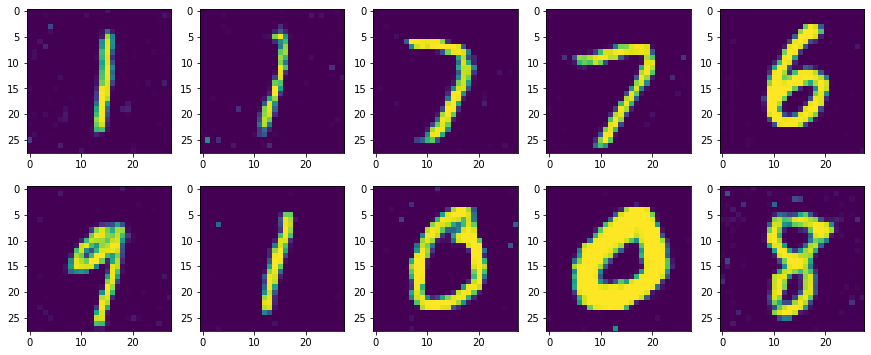

In [13]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

이러한 방법으로는 내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 함..

-> 같은 숫자 7이 많이 나온걸 볼 수 있다..

=> 내가 원하는 숫자를 바로 얻어내기 위해 cGAN을 학습시켜 보자!

***
cGAN으로 MNIST 학습하기
***

GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용

In [14]:
#위에 있는 gan_step()을 참고해서 cgan_step을 완성해주세요.

cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out =  cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.342392921447754, D:0.006409270688891411
[1/1 EPOCHS, 199 ITER] G:4.338807106018066, D:0.038456905633211136
[1/1 EPOCHS, 299 ITER] G:2.7475576400756836, D:0.12035651504993439
[1/1 EPOCHS, 399 ITER] G:3.504178047180176, D:0.04964692145586014


Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이 x

500 epoch 학습한 가중치를 준비해 두었으니 한번 사용

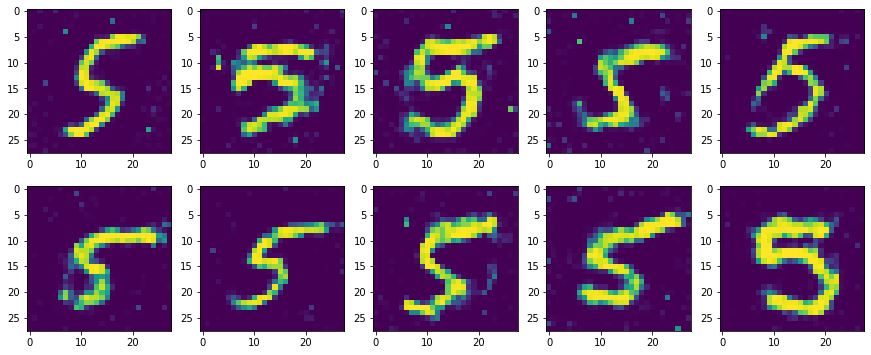

In [15]:
number =  5

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

number에 입력한 숫자에 해당하는 손글씨가 시각화

cGAN을 사용해 조건을 주고 학습하면 이렇게 특정한 숫자를 만들어내기가 훨씬 쉬워진다!

## GAN의 입력에 이미지를 넣는다면? Pix2Pix

 cGAN과 같이 클래스 레이블 등의 조건을 함께 입력하는 것이 아니라, 조금 더 자세하게 내가 원하는 이미지를 얻기 위해 이미지를 조건으로 줄 수 없을까?
 
 => Pix2Pix

    기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델

이미지를 다루는데 효율적인 convolution 레이어를 활용

GAN 구조를 기반으로 하기 때문에 크게 Generator와 Discriminator 두 가지 구성 요소로 이루어진다

***
Pix2Pix (Generator)
***

어떠한 이미지를 입력받아 변환된 이미지를 출력하기 위해 사용

여기서 입력 이미지와 변환된 이미지의 크기는 동일해야 하며, 이러한 문제에서 흔히 사용되는 구조는 아래 그림과 같은 Encoder-Decoder 구조

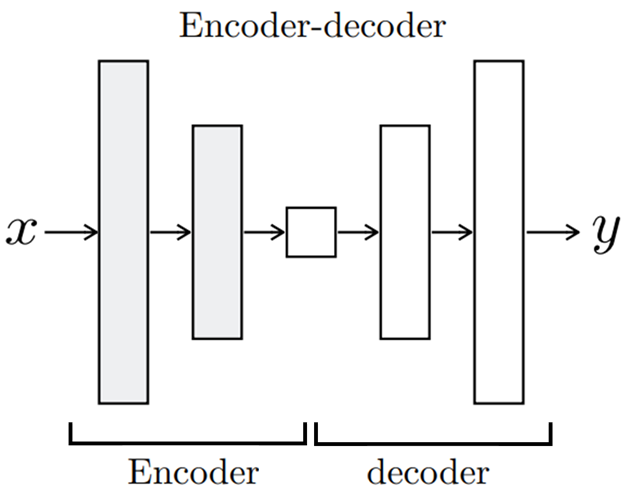

Encoder
- 입력 이미지(x)를 받으면 단계적으로 이미지를 down-sampling 하면서 입력 이미지의 중요한 representation을 학습

decoder
-  이를 이용해 반대로 다시 이미지를 up-sampling하여 입력 이미지와 동일한 크기의 변환된 이미지(y)를 생성

여기서 한 가지 짚고 넘어갈 부분은, Encoder의 최종 출력은 위 그림 중간에 위치한 가장 작은 사각형이며, bottleneck 이라고도 불리는 이 부분은 입력 이미지(x)의 가장 중요한 특징만을 담고 있다.

과연 이 중요하지만 작은 특징이 변환된 이미지(y)를 생성하는데 충분한 정보를 제공할까?

=> 이와 같은 점을 보완하기 위해 U-Net 구조

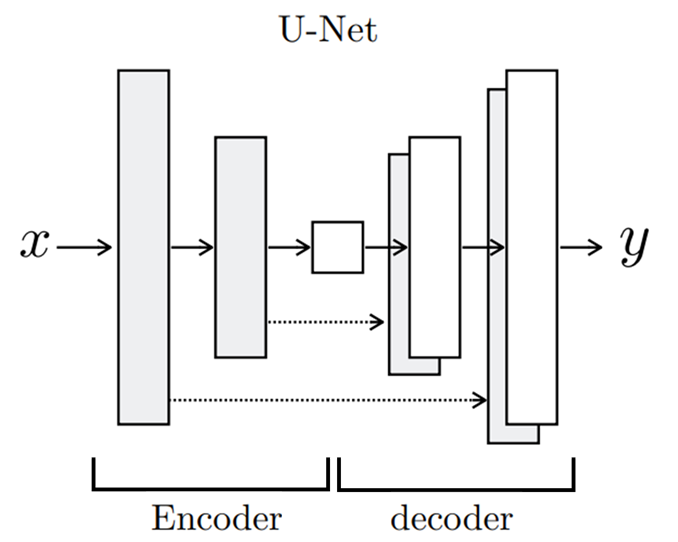

단순한 Encoder-Decoder로 구성된 Generator와 다른 점은, 각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있다는 것

비교적 선명한 결과

***
Pix2Pix (Loss Function)
***

 "Generator만으로도 이미지 변환이 가능하지 않을까?" 

A. Generator가 단순히 이미지의 평균적인 손실만을 줄이고자 파라미터를 학습하기 때문에 이러한 현상이 불가피

Discriminator를 잘 속이려면 Generator가 (Ground truth라고 쓰여진 이미지같이) 진짜 같은 이미지를 만들어야 하기 때문

***
Pix2Pix (Discriminator)
***

실제 같은 이미지를 얻기 위해서는 GAN의 학습 방법을 이용해야 하며, 위에서 설명한 Generator를 발전시킬 서포터이자 경쟁자, Discriminator가 필요

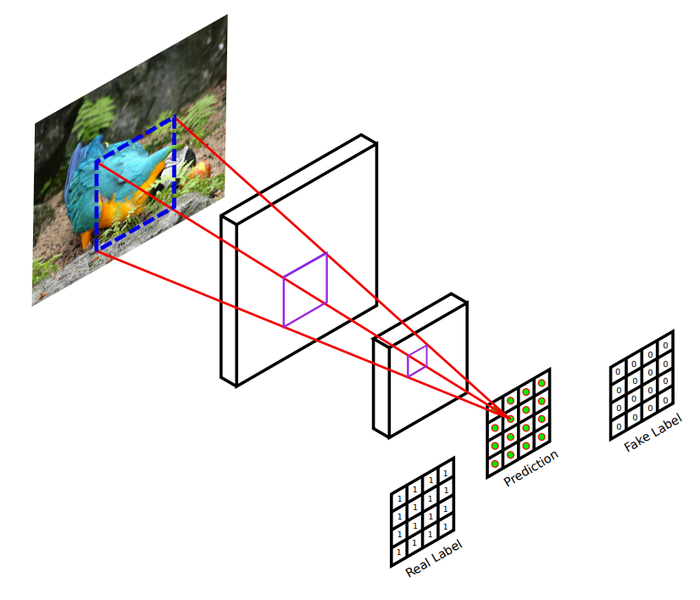

하나의 이미지가 Discriminator의 입력으로 들어오면, convolution 레이어를 거쳐 확률 값을 나타내는 최종 결과를 생성하는데, 그 결과는 하나의 값이 아닌 여러 개의 값을 갖는다 (위 그림의 Prediction은 16개의 값

서로 다른 영역에 대해 진짜/가짜를 나타내는 여러 개의 확률 값을 계산할 수 있으며 이 값을 평균하여 최종 Discriminator의 출력을 생성

=> 이미지의 일부 영역(patch)을 이용한다고 하여 PatchGAN

    이미지에서 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법

## 난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기

In [16]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


출처의 내용과 같이 830개 이미지가 있음을 확인
***

각각의 이미지들이 어떻게 생겼는지 확인

학습용 데이터셋에서 임의로 6장을 선택하여 시각화

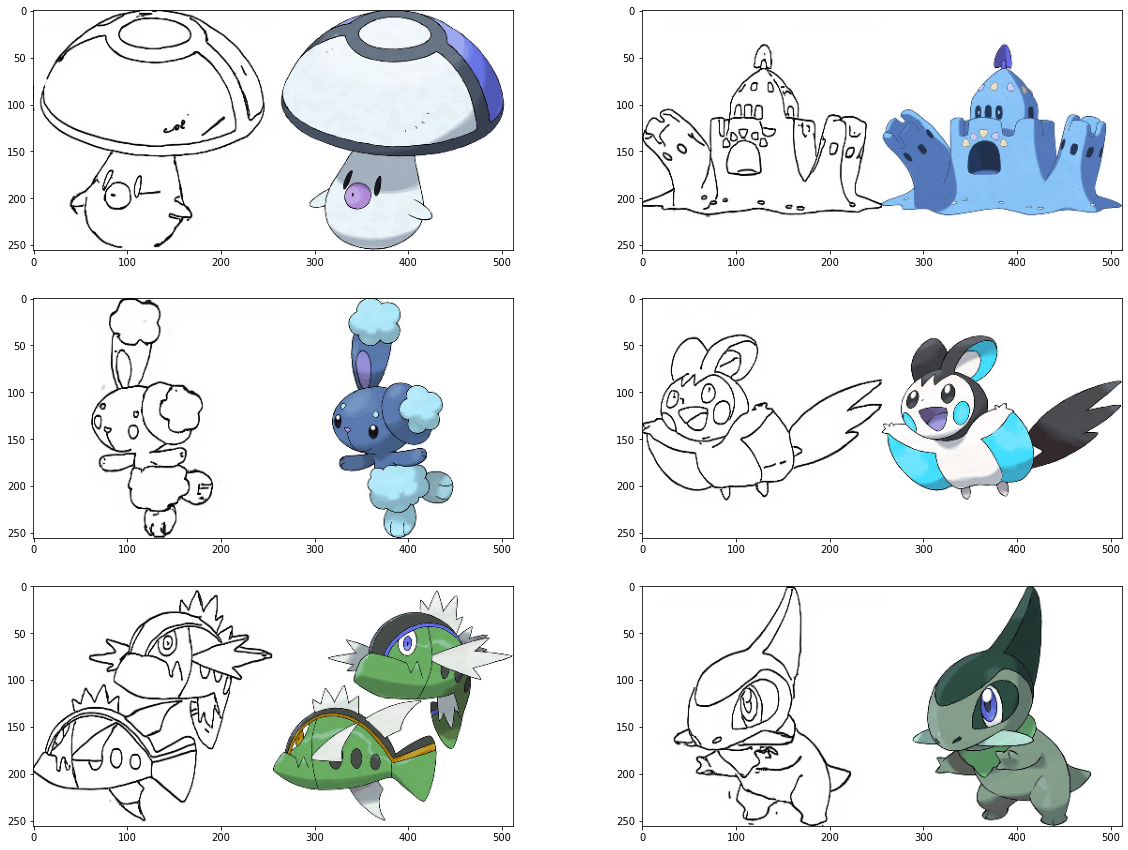

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

이미지를 하나 열어 아래와 같이 크기를 확인

In [18]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용

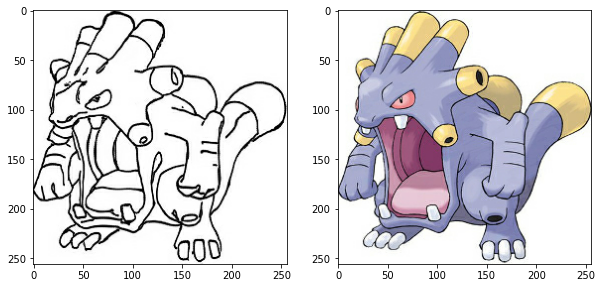

In [19]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

### 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표

학습에 사용할 수 있는 데이터의 수는 약 800개뿐

=> augmentation 방법을 적용
        
        기존 데이터를 변형, 확장 혹은 재구성하여 데이터셋의 크기를 증가시키는 기법
        모델의 일반화 능력을 향상시키거나 과대적합 방지, 데이터의 불균형 문제 해소를 위해 사용되고
        상하 혹은 좌우로 뒤집기, 회전, 크롭(Cropping), 확대 및 축소 등의 기법 존재

In [20]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1) # 채널 합치기
    
    _pad = tf.constant([[30,30],[30,30],[0,0]]) # pad 늘리기
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6]) # 임의로 자르기
    
    out = image.random_flip_left_right(out) # 가로로 뒤집기
    out = image.random_flip_up_down(out) # 새로로 뒤집기
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree) # 회전시키기
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용

위와 같이 구성한 함수를 데이터에 적용해 시각화

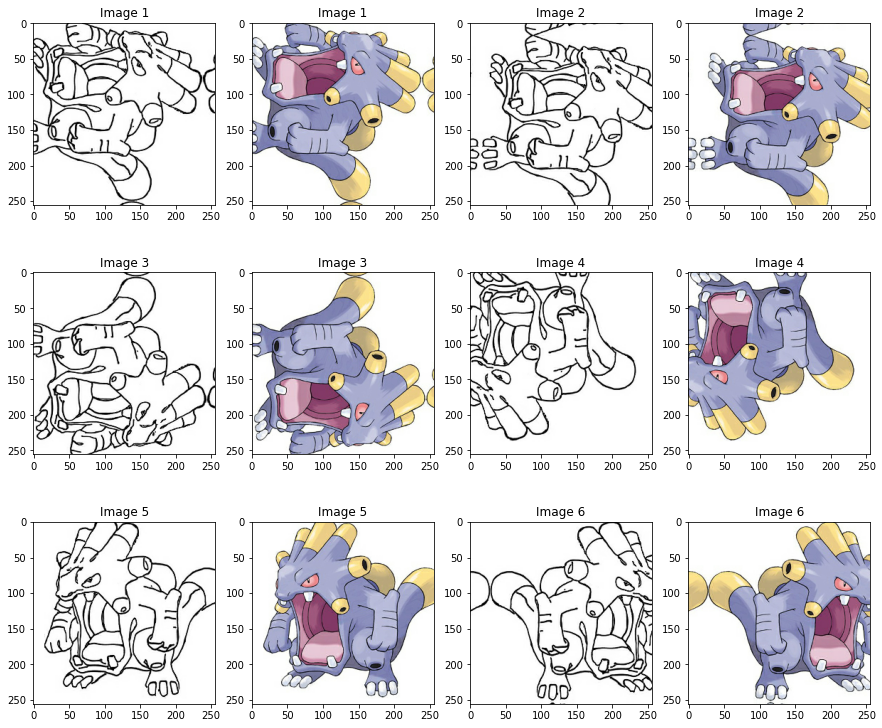

In [21]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인

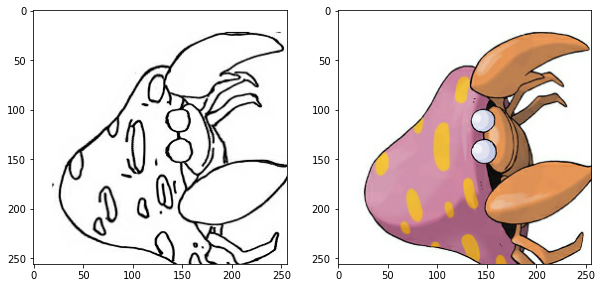

In [22]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기

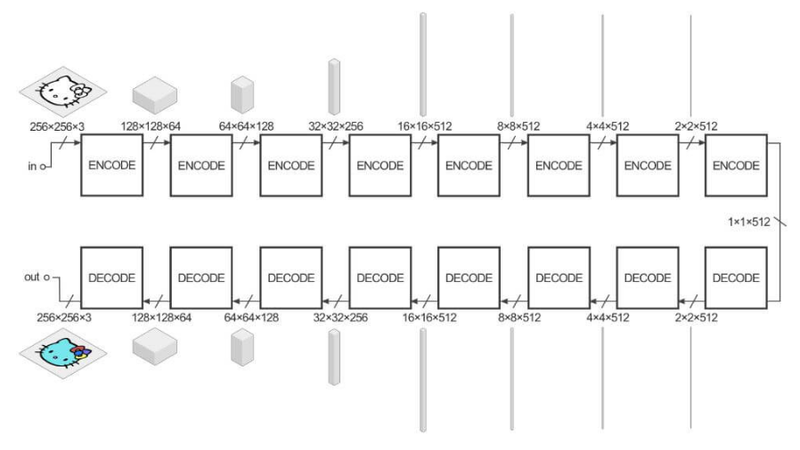

Generator 구현하기
***

1. Generator의 Encoder에 사용할 기본 블록을 구성

In [23]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정

2. Generator의 Encoder 부분을 구현

In [24]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        # for문과 리스트 filter를 활용해서 EncoderBlock을 쌓아주세요.
        # 조건 1. 첫번째 EncoderBlock의 경우 Batch Normalization을 생략해주세요.
        self.blocks = [] 
        for i, num_filters in enumerate(filters):
            if i == 0:
                # 첫 번째 EncoderBlock의 경우 Batch Normalization 생략
                self.blocks.append(EncodeBlock(num_filters, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(num_filters))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도

In [25]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

1. Generator의 Decoder에 사용할 기본 블록을 구성 + 2. Generator의 Decoder 부분을 구현

In [26]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        # for문을 이용해서 모델을 쌓아주세요.
        # 조건 1. 3번째 block까지는 Dropout을 사용하되 그 이후에는 Dropout을 사용하지 마세요.
        # for문이 끝난 다음 Conv2DTranspose를 쌓아주되 output 차원수는 3, filter 사이즈는 4, stride는 2로 구성해주시고 자동 패딩 적용해주시되 bias는 사용하지 않습니다.
        self.blocks = []
        for i, num_filters in enumerate(filters):
            # 3번째 block까지는 Dropout 사용, 그 이후에는 사용하지 않음
            use_dropout = i < 4
            self.blocks.append(DecodeBlock(num_filters, dropout=use_dropout))
        
        # Conv2DTranspose 레이어 추가
        self.final_layer = layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", use_bias=False)

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [27]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성

In [28]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 128, 128, 64)      19539712  
Total params: 39,084,288
Trainable params: 39,073,408
Non-trainable params: 10,880
_________________________________________________________________


Generator를 잘 작동시키기 위해서는 약 4000만 개의 파라미터를 잘 학습시켜야 한다.

## 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기

Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조

Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현

In [29]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


정의된 블록들을 이용해 한 번에 U-Net Generator를 정의

In [30]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = [] # 인코더
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = [] # 디코더
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = [] # skip connection을 위한 리스트
        for block in self.encode_blocks:
            x = block(x)
            features.append(x) # 인코더내에서 사용된 각 블록들의 출력 차례대로 담기
        
        features = features[:-1] # 인코더 마지막 출력은 skip connection 필요 x
                    
        for block, feat in zip(self.decode_blocks, features[::-1]): # 디코더의 입력으로 들어가면서 디코더 블록들 통과// 역순으로 연결
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 아래 코드로 확인

In [31]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

이전 Encoder-Decoder Generator 구조에서 학습해야 할 파라미터는 약 4000만 개였는데, Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만 개로 꽤나 많이 늘어났다!

    U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어난다.

## 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기

Generator만으로 좋은 결과를 도출하기에는 부족

조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요

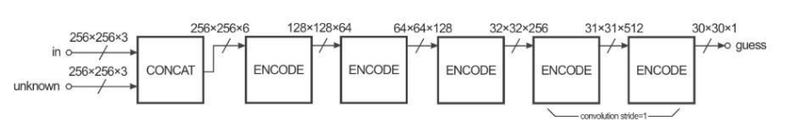

Discriminator 구현하기
***

 Discriminator에 사용할 기본적인 블록 만들기

In [32]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능

각 출력의 크기가 맞는지 확인

In [33]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


Discriminator를 만들기

In [34]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # filters = [64,128,256,512,1]
        self.block1 = layers.Concatenate()
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")

    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)


    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인

In [35]:
discriminator = Discriminator()
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block_5 (DiscBlock)        (None, 128, 128, 64) 6144        concatenate_9[0][0]        

시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화

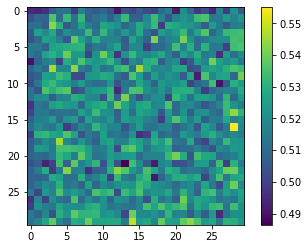

In [36]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기

두 가지 손실 함수를 모두 사용

In [37]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


사용할 optimizer

In [38]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현

In [39]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 x

gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 확인


***
정의한 함수를 이용해서 학습을 진행

우선 10 epoch 학습

In [40]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0695                     
L1_loss:0.5152                     
Discriminator_loss:1.0043

EPOCH[1] - STEP[20]                     
Generator_loss:1.6818                     
L1_loss:0.3404                     
Discriminator_loss:2.2290

EPOCH[1] - STEP[30]                     
Generator_loss:0.8406                     
L1_loss:0.2568                     
Discriminator_loss:1.1276

EPOCH[1] - STEP[40]                     
Generator_loss:0.7828                     
L1_loss:0.2458                     
Discriminator_loss:1.2157

EPOCH[1] - STEP[50]                     
Generator_loss:0.8055                     
L1_loss:0.3195                     
Discriminator_loss:1.1435

EPOCH[1] - STEP[60]                     
Generator_loss:1.5554                     
L1_loss:0.2700                     
Discriminator_loss:0.7649

EPOCH[1] - STEP[70]                     
Generator_loss:1.6640                     
L1_loss:0.2424                    

EPOCH[3] - STEP[170]                     
Generator_loss:2.7350                     
L1_loss:0.2681                     
Discriminator_loss:0.1873

EPOCH[3] - STEP[180]                     
Generator_loss:1.8567                     
L1_loss:0.2588                     
Discriminator_loss:0.4207

EPOCH[3] - STEP[190]                     
Generator_loss:1.7342                     
L1_loss:0.2995                     
Discriminator_loss:0.4310

EPOCH[3] - STEP[200]                     
Generator_loss:0.5625                     
L1_loss:0.2500                     
Discriminator_loss:1.2402

EPOCH[4] - STEP[10]                     
Generator_loss:1.8681                     
L1_loss:0.2264                     
Discriminator_loss:0.3586

EPOCH[4] - STEP[20]                     
Generator_loss:3.1752                     
L1_loss:0.2108                     
Discriminator_loss:2.2642

EPOCH[4] - STEP[30]                     
Generator_loss:1.0929                     
L1_loss:0.2486                

EPOCH[6] - STEP[130]                     
Generator_loss:0.6792                     
L1_loss:0.2580                     
Discriminator_loss:0.8819

EPOCH[6] - STEP[140]                     
Generator_loss:1.2239                     
L1_loss:0.1933                     
Discriminator_loss:1.2159

EPOCH[6] - STEP[150]                     
Generator_loss:1.2396                     
L1_loss:0.2437                     
Discriminator_loss:0.4475

EPOCH[6] - STEP[160]                     
Generator_loss:3.2225                     
L1_loss:0.2594                     
Discriminator_loss:0.1405

EPOCH[6] - STEP[170]                     
Generator_loss:2.7210                     
L1_loss:0.2633                     
Discriminator_loss:0.1526

EPOCH[6] - STEP[180]                     
Generator_loss:3.2354                     
L1_loss:0.3201                     
Discriminator_loss:0.9344

EPOCH[6] - STEP[190]                     
Generator_loss:2.0593                     
L1_loss:0.2550             

EPOCH[9] - STEP[90]                     
Generator_loss:1.4652                     
L1_loss:0.2520                     
Discriminator_loss:1.2106

EPOCH[9] - STEP[100]                     
Generator_loss:2.4736                     
L1_loss:0.2315                     
Discriminator_loss:0.2098

EPOCH[9] - STEP[110]                     
Generator_loss:1.0049                     
L1_loss:0.2861                     
Discriminator_loss:0.5670

EPOCH[9] - STEP[120]                     
Generator_loss:2.0414                     
L1_loss:0.2499                     
Discriminator_loss:0.7849

EPOCH[9] - STEP[130]                     
Generator_loss:0.6683                     
L1_loss:0.1848                     
Discriminator_loss:0.8372

EPOCH[9] - STEP[140]                     
Generator_loss:0.4611                     
L1_loss:0.2643                     
Discriminator_loss:1.1522

EPOCH[9] - STEP[150]                     
Generator_loss:0.7020                     
L1_loss:0.2357              

아래 코드로 짧게나마 학습해 본 모델에 채색을 시켜보자

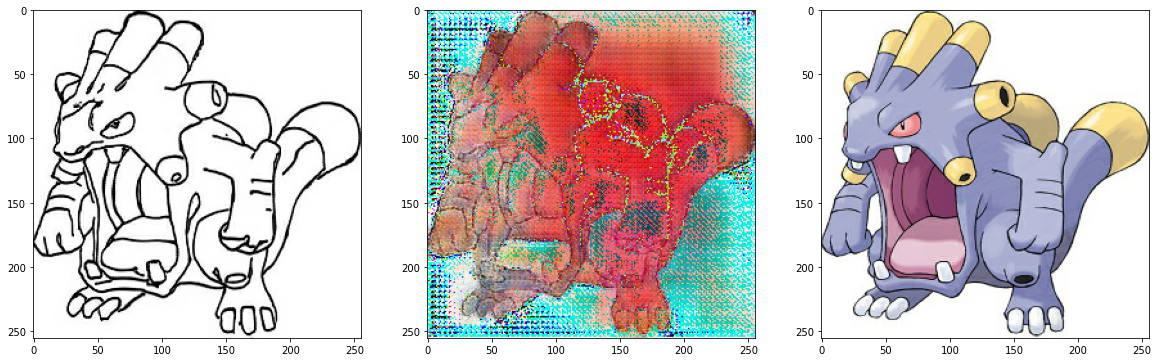

In [41]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

에폭 10으로는 좋지 못한 결과..